In [ ]:
import os
import json
import glob
import numpy as np
import pandas as pd
from scipy.io import wavfile
import torch
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import torch.utils.data as data_utils

import os
import sys
import random
import subprocess
from subprocess import call
import shutil
from shutil import copy, move
import errno
import time
import matplotlib.pyplot as plt
import matplotlib

import librosa
import librosa.display

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def download_nsynth(root):
    """Download NSynth data at root.
    Adapted from https://github.com/jthickstun/pytorch_musicnet

    Parameters
    ----------
    root : str, Path
        Directory to download NSynth data
    """
    from six.moves import urllib

    try:
        os.makedirs(os.path.join(root, "raw"))
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
    
    # Download nsynth-test.jsonwav.tar.gz
    url = "http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz"
    filename = url.rpartition('/')[2]
    file_path = os.path.join(root, "raw", filename)
    if not os.path.exists(file_path):
        print(f"Downloading {url}")
        data = urllib.request.urlopen(url)
        with open(file_path, 'wb') as f:
            # stream the download to disk (it might not fit in memory!)
            while True:
                chunk = data.read(16*1024)
                if not chunk:
                    break
                f.write(chunk)

    # Unpack nsynth-test.tar.gz
    extracted_folders = ["audio", "examples.json"]
    if not all(map(lambda f: os.path.exists(os.path.join(root, f)), extracted_folders)):
        print('Extracting ' + filename)
        if call(["tar", "-xf", file_path, '-C', root, '--strip', '1']) != 0:
            raise OSError("Failed tarball extraction")


In [ ]:
root = '/content/nsynth'
download_nsynth(root)

In [ ]:
class NSynth(data.Dataset):

    """Pytorch dataset for NSynth dataset
    args:
        root: root dir containing examples.json and audio directory with
            wav files.
        transform (callable, optional): A function/transform that takes in
                a sample and returns a transformed version.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
        blacklist_pattern: list of string used to blacklist dataset element.
            If one of the string is present in the audio filename, this sample
            together with its metadata is removed from the dataset.
        categorical_field_list: list of string. Each string is a key like
            instrument_family that will be used as a classification target.
            Each field value will be encoding as an integer using sklearn
            LabelEncoder.
    """

    def __init__(self, root, transform=None, target_transform=None,
                 blacklist_pattern=[],
                 categorical_field_list=["instrument_family"]):
        """Constructor"""
        assert(isinstance(root, str))
        assert(isinstance(blacklist_pattern, list))
        assert(isinstance(categorical_field_list, list))
        self.root = root
        self.filenames = glob.glob(os.path.join(root, "audio/*.wav"))
        with open(os.path.join(root, "examples.json"), "r") as f:
            self.json_data = json.load(f)
        for pattern in blacklist_pattern:
            self.filenames, self.json_data = self.blacklist(
                self.filenames, self.json_data, pattern)
        self.categorical_field_list = categorical_field_list
        self.le = []
        for i, field in enumerate(self.categorical_field_list):
            self.le.append(LabelEncoder())
            field_values = [value[field] for value in self.json_data.values()]
            self.le[i].fit(field_values)
        self.transform = transform
        self.target_transform = target_transform

    def blacklist(self, filenames, json_data, pattern):
        filenames = [filename for filename in filenames
                     if pattern not in filename]
        json_data = {
            key: value for key, value in json_data.items()
            if pattern not in key
        }
        return filenames, json_data

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (audio sample, *categorical targets, json_data)
        """
        name = self.filenames[index]
        _, sample = wavfile.read(name)
        target = self.json_data[os.path.splitext(os.path.basename(name))[0]]
        categorical_target = [
            le.transform([target[field]])[0]
            for field, le in zip(self.categorical_field_list, self.le)]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return [sample, *categorical_target, target]

In [ ]:
def parse_nsynth(root, json_name):
    df_json = pd.read_json(os.path.join(root, json_name))

    instr_str_strip = df_json.loc["instrument_str"].apply(lambda x: "_".join(x.split("_")[:2])).unique()

    parsed_dir = os.path.join(root, 'parsed')
    os.makedirs(parsed_dir, exist_ok=True)

    for instr_str in instr_str_strip:
            os.makedirs(os.path.join(parsed_dir, instr_str), exist_ok=True)

    filenames = glob.glob(os.path.join(root, "audio/*.wav"))
    for fname in filenames:
        fname_base = os.path.basename(fname).split(".")[0]
        family = df_json[fname_base].loc["instrument_family_str"]
        src = df_json[fname_base].loc["instrument_source_str"]

        dst_dir = os.path.join(parsed_dir, "_".join([family, src]))

        copy(fname, dst_dir)

In [ ]:
def split_nsynth(root, train_ratio=0.8):

    parsed_dir = os.path.join(root, 'parsed')
    split_dir = os.path.join(root, 'split')
    os.makedirs(split_dir, exist_ok=True)

    instr_str_dirs = glob.glob(parsed_dir +'/*')
    for dir in instr_str_dirs:
        instr_files = glob.glob(dir + '/*.wav')
        num_files = len(instr_files)

        num_train = int(train_ratio*num_files)
        train_files = instr_files[:num_train]
        test_files = instr_files[num_train:]

        train_dir = os.path.join(dir.replace('parsed', 'split'), 'train')
        os.makedirs(train_dir, exist_ok=True)
        test_dir = os.path.join(dir.replace('parsed', 'split'), 'test')
        os.makedirs(test_dir, exist_ok=True)

        for train_f in train_files:
            copy(train_f, train_dir)
        for test_f in test_files:
            copy(test_f, test_dir)

In [1]:
parse_nsynth(root, 'examples.json')
split_nsynth(root)

temp = os.listdir("./nsynth/parsed/")

temp.remove("keyboard_acoustic")
temp.remove("keyboard_electronic")
temp.remove("string_acoustic")

NameError: ignored

In [ ]:
# Splitting training dataset into training and validation and testing
dataset_train = NSynth(root, blacklist_pattern=temp, categorical_field_list=["instrument_family_str"]) #TODO fill in instrument families

num_train = len(dataset_train)
indices = list(range(num_train))
splitVal = int(np.floor(0.2 * num_train))
splitTest = int(np.floor(0.1 * num_train)) + splitVal

# Shuffle the indices
np.random.shuffle(indices)

# Get training set index and validation set index
validation_idx, test_idx, train_idx = indices[:splitVal], \
                                      indices[splitVal:splitTest], \
                                      indices[splitTest:]

 # create samplers
train_sampler = data_utils.SubsetRandomSampler(train_idx)
test_sampler = data_utils.SubsetRandomSampler(test_idx)
validation_sampler = data_utils.SubsetRandomSampler(validation_idx)

 # create dataLoaders
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                batch_size=16, sampler=train_sampler, collate_fn=lambda x: x )

val_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                batch_size=8, sampler=validation_sampler, collate_fn=lambda x: x )

test_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                batch_size=8, sampler=test_sampler, collate_fn=lambda x: x )

In [ ]:
print(*dataset_train[0], sep='\n')
# for t in train_loader:
#   if len(t[2]) != 13:
#     print(len(t[2]))



[ 28  30 104 ...   0   0   0]
0
{'qualities': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'pitch': 105, 'note': 218326, 'instrument_source_str': 'acoustic', 'velocity': 25, 'instrument_str': 'keyboard_acoustic_004', 'instrument': 327, 'sample_rate': 16000, 'qualities_str': ['reverb'], 'instrument_source': 0, 'note_str': 'keyboard_acoustic_004-105-025', 'instrument_family': 4, 'instrument_family_str': 'keyboard'}


# RNN Model

In [ ]:
"""
LSTM Model from
@author: Parinitha Nagaraja and Qiaoran Li 
"""

gpu_boole = torch.cuda.is_available()

# Network Parameters
INPUT_SIZE = 160
HIDDEN_SIZE = 128
NUM_LAYERS = 3

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        # if use nn.RNN(), it hardly learns
        self.rnn = nn.LSTM(         
            input_size=INPUT_SIZE,
            # rnn hidden unit
            hidden_size=HIDDEN_SIZE,   
            # number of rnn layer
            num_layers= NUM_LAYERS,
            # input & output will has batch size as 1s dimension. 
            # e.g. (batch, time_step, input_size)
            batch_first=True,
        )

        self.out = nn.Linear(HIDDEN_SIZE, 2) #TODO change instrument classification here

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        h0 = torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE)
        c0 = torch.zeros(NUM_LAYERS, x.size(0), HIDDEN_SIZE)

        # None represents zero initial hidden state
        r_out, (h_n, h_c) = self.rnn(x, (h0,c0))   

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        #out = F.softmax(out)
        return out

In [ ]:
def train(model,
          optimizer,
          loss_f,
          epochs=10,
          train_dataloader=train_loader,
          val_dataloader=val_loader,
          test_dataloader=test_loader,
          gpu_boole=False,
          **kwargs):
    """
    
    """
    print("Starting Training")
    train_loss_store = []
    train_val_test_acc = [[],[],[]]

    for epoch in range(epochs):
      correct = 0
      model.train()
      time1 = time.time() #timekeeping

      for i, data in enumerate(train_dataloader):
        if i > 0 or epoch > 0:
          optimizer.zero_grad()

        if gpu_boole:
          data = data.cuda()
        
        x = torch.FloatTensor([triplet[0] for triplet in data])
        inputs = x[:, 0:48000]
        inputs = inputs.view((len(inputs),300,160))
        labels = torch.LongTensor([triplet[1] for triplet in data])

        outputs = model.forward(inputs)
        probabilities, predicted = torch.max(outputs.data, 1)

        loss = loss_f(outputs,labels)
        loss.backward()

        optimizer.step()
        torch.cuda.empty_cache()
        correct += (predicted == labels).sum().item()

        if i % 10 == 0:
          print(i, ' ', loss.data.numpy())
      
      train_loss_store.append(loss.data.numpy().item())

      model.eval()
      print("Epoch",epoch+1,':')
      val_perc, val_loss = val_eval(model, val_dataloader, loss_f, gpu_boole)
      test_perc, test_loss = test_eval(model, test_dataloader, loss_f, gpu_boole)

      train_perc = correct / len(train_dataloader)
      train_val_test_acc[0].append(train_perc)
      train_val_test_acc[1].append(val_perc)
      train_val_test_acc[2].append(test_perc)
  
      time2 = time.time() #timekeeping
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')

    ## Plotting epoch-wise train loss curve:
    plt.plot(train_loss_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Loss At Last epoch')
    plt.legend()
    plt.show()

    ## Plotting epoch-wise test loss curve:
    plt.plot(train_val_test_acc[0], '-o', label = 'train_acc', color = 'orange')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Accuracy At Last epoch')
    plt.legend()
    plt.show()

    ## Plotting epoch-wise test loss curve:
    plt.plot(train_val_test_acc[1], '-o', label = 'val_acc', color = 'orange')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Accuracy At Last epoch')
    plt.legend()
    plt.show()

    ## Plotting epoch-wise test loss curve:
    plt.plot(train_val_test_acc[2], '-o', label = 'test_acc', color = 'orange')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Accuracy At Last epoch')
    plt.legend()
    plt.show()

def val_eval(model, val_dataloader, loss_metric, gpu_boole, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for i, data in enumerate(val_dataloader):
        if gpu_boole:
          data = data.cuda()
        
        x = torch.FloatTensor([triplet[0] for triplet in data])
        inputs = x[:, 0:48000]
        inputs = inputs.view((len(inputs),300,160))
        labels = torch.LongTensor([triplet[1] for triplet in data])

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss_sum += loss_metric(outputs,labels).cpu().data.numpy().item()

    if verbose:
        print('Eval accuracy: %f %%' % (100.0 * correct / total))
        print('Eval loss: %f' % (loss_sum / labels.size(0)))

    return 100.0 * correct / total, loss_sum / len(val_dataloader)

def test_eval(model, test_dataloader, loss_metric, gpu_boole, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for i, data in enumerate(test_dataloader):
        if gpu_boole:
          data = data.cuda()
        
        x = torch.FloatTensor([triplet[0] for triplet in data])
        inputs = x[:, 0:48000]
        inputs = inputs.view((len(inputs),300,160))
        labels = torch.LongTensor([triplet[1] for triplet in data])

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss_sum += loss_metric(outputs,labels).cpu().data.numpy().item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / labels.size(0)))

    return 100.0 * correct / total, loss_sum / len(test_dataloader)

Starting Training
0   0.06834169
10   0.41427633
20   0.18552837
30   0.6074768
40   0.21900183
Epoch 1 :
Eval accuracy: 92.187500 %
Eval loss: 0.801290
Test accuracy: 87.500000 %
Test loss: 0.670046
Elapsed time for epoch: 42.84091305732727 s
ETA of completion: 13.566289134820302 minutes
0   0.43142262
10   0.3154043
20   0.2980995
30   0.28721106
40   0.0660195
Epoch 2 :
Eval accuracy: 82.812500 %
Eval loss: 1.051281
Test accuracy: 81.250000 %
Test loss: 0.654265
Elapsed time for epoch: 50.71485757827759 s
ETA of completion: 15.214457273483276 minutes
0   0.23086625
10   0.08978678
20   0.3406819
30   0.08186005
40   0.17563277
Epoch 3 :
Eval accuracy: 85.416667 %
Eval loss: 1.061935
Test accuracy: 78.125000 %
Test loss: 0.854632
Elapsed time for epoch: 52.01689434051514 s
ETA of completion: 14.738120063145955 minutes
0   0.13728318
10   0.17671344
20   0.13277689
30   0.2192718
40   0.75333315
Epoch 4 :
Eval accuracy: 83.333333 %
Eval loss: 1.044784
Test accuracy: 82.291667 %
Test l

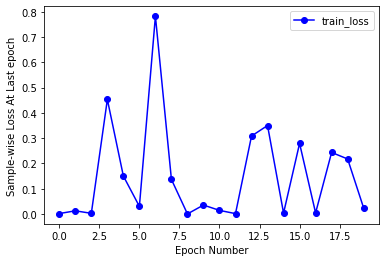

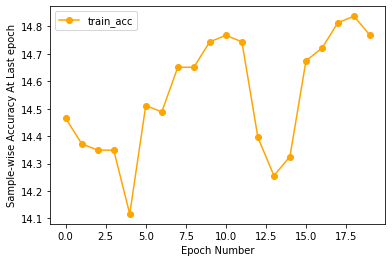

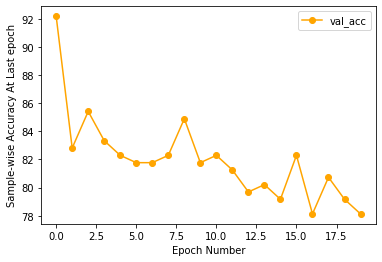

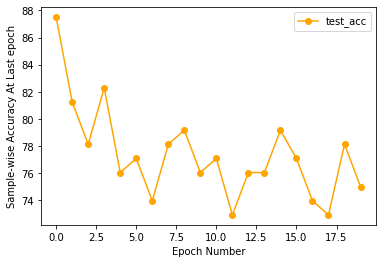

In [ ]:
path = '/content/gdrive/MyDrive/DL Final Project/'

model = RNN()
model.load_state_dict(torch.load(path + "RNNmodel.pt"))

if gpu_boole:
  model = model.cuda()

LR = 3e-4
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train(model, optimizer, criterion, epochs=EPOCHS, train_loader=train_loader, val_dataloader=val_loader,
      test_dataloader=test_loader, gpu_boole=False)

In [ ]:
path = '/content/gdrive/MyDrive/DL Final Project/'

torch.save(model.state_dict(), path + "RNNmodel.pt")